# Root Cause Analysis - PyRCA

## Import all the necessary libraries

In [46]:
import networkx as nx
import numpy as np
import pyrca

from pyrca.analyzers.ht import HT, HTConfig
from pyrca.analyzers.epsilon_diagnosis import EpsilonDiagnosis, EpsilonDiagnosisConfig
from pyrca.analyzers.bayesian import BayesianNetwork, BayesianNetworkConfig
from pyrca.analyzers.random_walk import RandomWalk, RandomWalkConfig
from pyrca.analyzers.rcd import RCD, RCDConfig

import matplotlib.pyplot as plt
import pandas as pd
import os

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


## Custom Functions

In [47]:
def draw_save(G,pos,node_colors,file_name:str, inter_type:str):
    # Draw the graph
    plt.figure(figsize=(12, 10))
    plt.xlim((-12,14))
    plt.ylim((-12,8))
    plt.title(f'Causal Graph: {inter_type}', fontsize=15)
    nx.draw(G, pos,with_labels=True,node_size=2000, node_color=[node_colors[node] for node in G.nodes()], font_size=8, arrowsize=10,width=0.5)
    plt.savefig(file_name)
    nx.write_gml(G, f'{file_name[:-4]}.gml')

def get_file_name(var:str):
    return var[7:-4]

def create_data_from_list(files):
    data_df = pd.DataFrame()
    for file in files:
        to_join_df = file
        data_df = pd.concat([data_df,to_join_df.loc[to_join_df.index]],ignore_index=True)
    return data_df

def create_train_data(files,startrow):
    data_df = pd.DataFrame()
    for file_key, file_path in files.items():
        to_join_df =  pd.read_csv(file_path, skiprows=range(1, startrow))
        data_df = pd.concat([data_df,to_join_df.loc[to_join_df.index]],ignore_index=True)
    return data_df

def get_from_dir(directory_path):
    # Get a list of all items (files and directories) in the specified path
    all_items = os.listdir(directory_path)
    # Iterate over each item and check if it's a directory
    for item in all_items:
        folder_path = os.path.join(directory_path, item)
        if os.path.isdir(folder_path):
            print(f"\nProcessing folder: {item}")
            folder_contents = os.listdir(folder_path)
            for file in folder_contents:
                file_path = os.path.join(folder_path, file)
                print(f"    -> {file}")

def get_from_folder(directory_path,folder):
    files = {}
    folder_path = os.path.join(directory_path, folder)
    if os.path.isdir(folder_path):
        print(f"Selected folder: {folder}")
        folder_contents = os.listdir(folder_path)
        for file in folder_contents:
            file_path = os.path.join(folder_path, file)
            print(f"-> {file}")
            if file[0:4] == 'data':
                files[f"{get_file_name(file)}"] = file_path
    return files, folder_path

# Function run hypothesis testing algorithm
def run_HT(folder_path: str,
           files: dict,
           startrow: int,
           G: nx.DiGraph,
           nodes: list,
           edges:dict,
           key_nodes: list,
           colors: dict,
           pos: dict):
     
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)  # Make sure `edges` is defined somewhere

    adj_matrix_extended_pd = nx.to_pandas_adjacency(G, nodes)
    
    interventions = ['gripper_1', 'gripper_2', 'max_Vel_1', 'max_Vel_2', 'camera_1', 'camera_2', 'camera_3',
                     'conveyor_1', 'conveyor_2', 'conveyor_3']
    abnormal_files = {}
    file_names = []

    if 'normal' not in files:
        print('No normal data file found in folder!!')
        return

    for file_key, file_path in files.items():
        if file_key == 'normal':
            normal_data_df = pd.read_csv(file_path, skiprows=range(1, startrow))
            normal_data_df = normal_data_df[nodes]
            folder_name = 'Results'
            filename = f'{file_key}_HT.png'
            path = os.path.join(folder_path, folder_name)
            os.makedirs(path, exist_ok=True)
            file_name_save = os.path.join(path, filename)
            draw_save(G, pos, colors, file_name_save, file_key)
        
        if file_key in interventions:
            abnormal_files[file_key] = file_path
            file_names.append(file_key)
    
    if not file_names:
        print('No abnormal data in folder found!!')
        return
    
    abnormal_paths_df = pd.DataFrame.from_dict(abnormal_files, orient='index', columns=['file_path'])

    model = HT(config=HTConfig(adj_matrix_extended_pd))
    model.train(normal_data_df)

    for file_counter, abnormal_file_path in enumerate(abnormal_paths_df.values.flatten()):
        abnormal_data_df = pd.read_csv(abnormal_file_path, skiprows=range(1, startrow))
        abnormal_data_df = abnormal_data_df[nodes]

        abnormal_nodes = []
        new_colors = colors.copy()

        results = pd.DataFrame()
        for node in key_nodes:
            if (abnormal_data_df[node] == 0.0).any():
                abnormal_nodes.append(node)
                new_colors[node] = 'yellow'
                results[node] = model.find_root_causes(abnormal_data_df, node, True).to_list()
        
        results_file_name = f'results_{file_names[file_counter]}_HT.csv'
        results.to_csv(os.path.join(path, results_file_name), index=False)
        
        rank1_root_cause = []
        rank2_root_cause = []
        rank3_root_cause = []

        for node in abnormal_nodes:
            rank1_root_cause.append(results[node][0]['root_cause'])
            rank2_root_cause.append(results[node][1]['root_cause'])
            rank3_root_cause.append(results[node][2]['root_cause'])

        for node in rank1_root_cause:
            new_colors[node] = 'red'

        for node in rank2_root_cause:
            new_colors[node] = 'crimson'

        for node in rank3_root_cause:
            new_colors[node] = 'lightcoral'

        filename = f'{file_names[file_counter]}_HT.png'

        file_name_save = os.path.join(path, filename)

        draw_save(G, pos, new_colors, file_name_save, file_names[file_counter])

# Function run epsilon diagnosis algorithm
def run_ED(folder_path: str,
           files: dict,
           startrow: int,
           G: nx.DiGraph,
           nodes: list,
           edges:dict,
           key_nodes: list,
           colors: dict,
           pos: dict):
     
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)  # Make sure `edges` is defined somewhere

    adj_matrix_extended_pd = nx.to_pandas_adjacency(G, nodes)
    
    interventions = ['gripper_1', 'gripper_2', 'max_Vel_1', 'max_Vel_2', 'camera_1', 'camera_2', 'camera_3',
                     'conveyor_1', 'conveyor_2', 'conveyor_3']
    abnormal_files = {}
    file_names = []

    if 'normal' not in files:
        print('No normal data file found in folder!!')
        return

    for file_key, file_path in files.items():
        if file_key == 'normal':
            normal_data_df = pd.read_csv(file_path, skiprows=range(1, startrow))
            normal_data_df = normal_data_df[nodes]
            folder_name = 'Results'
            filename = f'{file_key}_HT.png'
            path = os.path.join(folder_path, folder_name)
            os.makedirs(path, exist_ok=True)
            file_name_save = os.path.join(path, filename)
            draw_save(G, pos, colors, file_name_save, file_key)
        
        if file_key in interventions:
            abnormal_files[file_key] = file_path
            file_names.append(file_key)
    
    if not file_names:
        print('No abnormal data in folder found!!')
        return
    
    abnormal_paths_df = pd.DataFrame.from_dict(abnormal_files, orient='index', columns=['file_path'])

    model = EpsilonDiagnosis(EpsilonDiagnosisConfig(alpha=0.05))
    model.train(normal_data_df)

    for file_counter, abnormal_file_path in enumerate(abnormal_paths_df.values.flatten()):
        abnormal_data_df = pd.read_csv(abnormal_file_path, skiprows=range(1, startrow))
        abnormal_data_df = abnormal_data_df[nodes]

        abnormal_nodes = []
        new_colors = colors.copy()

        for node in key_nodes:
            # Basic Anomaly Detection
            if (abnormal_data_df[node] == 0.0).any():
                abnormal_nodes.append(node)
                new_colors[node] = 'yellow'

        results = model.find_root_causes(abnormal_data_df)

        results_file_name = f'results_{file_names[file_counter]}_ED.csv'
        
        root_cause_nodes = pd.DataFrame(results.root_cause_nodes)
        
        root_cause_nodes.to_csv(os.path.join(path, results_file_name), index=False)

        new_colors[root_cause_nodes[0][0]] = 'red'

        new_colors[root_cause_nodes[0][1]] = 'crimson'

        new_colors[root_cause_nodes[0][2]] = 'indianred'

        filename = f'{file_names[file_counter]}_ED.png'

        file_name_save = os.path.join(path, filename)

        draw_save(G, pos, new_colors, file_name_save, file_names[file_counter])

# Function run random walk algorithm
def run_RW(folder_path: str,
           files: dict,
           train_file:pd.DataFrame,
           startrow: int,
           G: nx.DiGraph,
           nodes: list,
           edges:dict,
           key_nodes: list,
           colors: dict,
           pos: dict):
     
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)  # Make sure `edges` is defined somewhere

    adj_matrix_extended_pd = nx.to_pandas_adjacency(G, nodes)
    adj_matrix_extended = nx.adjacency_matrix(G,nodes).todense()
    adjacency_df = pd.DataFrame(adj_matrix_extended, index=G.nodes(), columns=G.nodes())
    
    interventions = ['gripper_1', 'gripper_2', 'max_Vel_1', 'max_Vel_2', 'camera_1', 'camera_2', 'camera_3',
                     'conveyor_1', 'conveyor_2', 'conveyor_3']
    abnormal_files = {}
    file_names = []

    if 'normal' not in files:
        print('No normal data file found in folder!!')
        return

    for file_key, file_path in files.items():
        if file_key == 'normal':
            normal_data_df = pd.read_csv(file_path, skiprows=range(1, startrow))
            normal_data_df = normal_data_df[nodes]
            folder_name = 'Results'
            filename = f'{file_key}_RW.png'
            path = os.path.join(folder_path, folder_name)
            os.makedirs(path, exist_ok=True)
            file_name_save = os.path.join(path, filename)
            draw_save(G, pos, colors, file_name_save, file_key)
        
        if file_key in interventions:
            abnormal_files[file_key] = file_path
            file_names.append(file_key)
    
    if not file_names:
        print('No abnormal data in folder found!!')
        return
    
    abnormal_paths_df = pd.DataFrame.from_dict(abnormal_files, orient='index', columns=['file_path'])

    model = RandomWalk(RandomWalkConfig(graph=adjacency_df,root_cause_top_k=3))


    for file_counter, abnormal_file_path in enumerate(abnormal_paths_df.values.flatten()):
        abnormal_data_df = pd.read_csv(abnormal_file_path, skiprows=range(1, startrow))
        abnormal_data_df = abnormal_data_df[nodes]

        abnormal_nodes = []
        new_colors = colors.copy()

        for node in key_nodes:
            # Basic Anomaly Detection
            if (abnormal_data_df[node] == 0.0).any():
                abnormal_nodes.append(node)
                new_colors[node] = 'yellow'

        results = model.find_root_causes(abnormal_nodes,create_data_from_list([train_file,abnormal_data_df,normal_data_df]))

        results_file_name = f'results_{file_names[file_counter]}_RW.csv'
        
        root_cause_nodes = pd.DataFrame(results.root_cause_nodes)
        
        root_cause_nodes.to_csv(os.path.join(path, results_file_name), index=False)

        new_colors[root_cause_nodes[0][0]] = 'red'

        new_colors[root_cause_nodes[0][1]] = 'crimson'

        new_colors[root_cause_nodes[0][2]] = 'indianred'

        filename = f'{file_names[file_counter]}_RW.png'

        file_name_save = os.path.join(path, filename)

        draw_save(G, pos, new_colors, file_name_save, file_names[file_counter])

# Function run Root cause discovery algorithm
def run_RCD(folder_path: str,
           files: dict,
           startrow: int,
           G: nx.DiGraph,
           nodes: list,
           edges:dict,
           key_nodes: list,
           colors: dict,
           pos: dict):
     
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)  # Make sure `edges` is defined somewhere

    adj_matrix_extended_pd = nx.to_pandas_adjacency(G, nodes)
    adj_matrix_extended = nx.adjacency_matrix(G,nodes).todense()
    adjacency_df = pd.DataFrame(adj_matrix_extended, index=G.nodes(), columns=G.nodes())
    
    interventions = ['gripper_1', 'gripper_2', 'max_Vel_1', 'max_Vel_2', 'camera_1', 'camera_2', 'camera_3',
                     'conveyor_1', 'conveyor_2', 'conveyor_3']
    abnormal_files = {}
    file_names = []

    if 'normal' not in files:
        print('No normal data file found in folder!!')
        return

    for file_key, file_path in files.items():
        if file_key == 'normal':
            normal_data_df = pd.read_csv(file_path, skiprows=range(1, startrow))
            normal_data_df = normal_data_df[nodes]
            folder_name = 'Results'
            filename = f'{file_key}_RW.png'
            path = os.path.join(folder_path, folder_name)
            os.makedirs(path, exist_ok=True)
            file_name_save = os.path.join(path, filename)
            draw_save(G, pos, colors, file_name_save, file_key)
        
        if file_key in interventions:
            abnormal_files[file_key] = file_path
            file_names.append(file_key)
    
    if not file_names:
        print('No abnormal data in folder found!!')
        return
    
    abnormal_paths_df = pd.DataFrame.from_dict(abnormal_files, orient='index', columns=['file_path'])

    model = RCD(RCDConfig())
    
    for file_counter, abnormal_file_path in enumerate(abnormal_paths_df.values.flatten()):
        abnormal_data_df = pd.read_csv(abnormal_file_path, skiprows=range(1, startrow))
        abnormal_data_df = abnormal_data_df[nodes]

        abnormal_nodes = []
        new_colors = colors.copy()

        results = pd.DataFrame()
        for node in key_nodes:
            if (abnormal_data_df[node] == 0.0).any():
                abnormal_nodes.append(node)
                new_colors[node] = 'yellow'
                results[node] = model.find_root_causes(normal_data_df,abnormal_data_df).to_list()
        
        print(results)
        
        # results_file_name = f'results_{file_names[file_counter]}_HT.csv'
        # results.to_csv(os.path.join(path, results_file_name), index=False)
        
        # rank1_root_cause = []
        # rank2_root_cause = []
        # rank3_root_cause = []

        # for node in abnormal_nodes:
        #     rank1_root_cause.append(results[node][0]['root_cause'])
        #     rank2_root_cause.append(results[node][1]['root_cause'])
        #     rank3_root_cause.append(results[node][2]['root_cause'])

        # for node in rank1_root_cause:
        #     new_colors[node] = 'red'

        # for node in rank2_root_cause:
        #     new_colors[node] = 'crimson'

        # for node in rank3_root_cause:
        #     new_colors[node] = 'lightcoral'

        # filename = f'{file_names[file_counter]}_HT.png'

        # file_name_save = os.path.join(path, filename)

        # draw_save(G, pos, new_colors, file_name_save, file_names[file_counter])

# Function run bayesian network algorithm
def run_BN(folder_path: str,
           files: dict,
           train_file:pd.DataFrame,
           startrow: int,
           G: nx.DiGraph,
           nodes: list,
           edges:dict,
           key_nodes: list,
           colors: dict,
           pos: dict):
     
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)  # Make sure `edges` is defined somewhere

    adj_matrix_extended_pd = nx.to_pandas_adjacency(G, nodes)
    adj_matrix_extended = nx.adjacency_matrix(G,nodes).todense()
    adjacency_df = pd.DataFrame(adj_matrix_extended, index=G.nodes(), columns=G.nodes())
    
    interventions = ['gripper_1', 'gripper_2', 'max_Vel_1', 'max_Vel_2', 'camera_1', 'camera_2', 'camera_3',
                     'conveyor_1', 'conveyor_2', 'conveyor_3']
    abnormal_files = {}
    file_names = []

    if 'normal' not in files:
        print('No normal data file found in folder!!')
        return

    for file_key, file_path in files.items():
        if file_key == 'normal':
            normal_data_df = pd.read_csv(file_path, skiprows=range(1, startrow))
            normal_data_df = normal_data_df[nodes]
            folder_name = 'Results'
            filename = f'{file_key}_RW.png'
            path = os.path.join(folder_path, folder_name)
            os.makedirs(path, exist_ok=True)
            file_name_save = os.path.join(path, filename)
            draw_save(G, pos, colors, file_name_save, file_key)
        
        if file_key in interventions:
            abnormal_files[file_key] = file_path
            file_names.append(file_key)
    
    if not file_names:
        print('No abnormal data in folder found!!')
        return
    
    abnormal_paths_df = pd.DataFrame.from_dict(abnormal_files, orient='index', columns=['file_path'])

    model = BayesianNetwork(BayesianNetworkConfig(adjacency_df,thres_reduce_func="median",root_cause_top_k=3))

    abnormal_train_data = create_train_data(abnormal_files,startrow)
    
    model.train(create_data_from_list([train_file,abnormal_train_data,normal_data_df]))

    # for file_counter, abnormal_file_path in enumerate(abnormal_paths_df.values.flatten()):
    #     abnormal_data_df = pd.read_csv(abnormal_file_path, skiprows=range(1, startrow))
    #     abnormal_data_df = abnormal_data_df[nodes]

    #     abnormal_nodes = []
    #     new_colors = colors.copy()

    #     for node in key_nodes:
    #         # Basic Anomaly Detection
    #         if (abnormal_data_df[node] == 0.0).any():
    #             abnormal_nodes.append(node)
    #             new_colors[node] = 'yellow'

    #     results = model.find_root_causes(abnormal_nodes)

    #     print(results)

        # results_file_name = f'results_{file_names[file_counter]}_RW.csv'
        
        # root_cause_nodes = pd.DataFrame(results.root_cause_nodes)
        
        # root_cause_nodes.to_csv(os.path.join(path, results_file_name), index=False)

        # new_colors[root_cause_nodes[0][0]] = 'red'

        # new_colors[root_cause_nodes[0][1]] = 'crimson'

        # new_colors[root_cause_nodes[0][2]] = 'indianred'

        # filename = f'{file_names[file_counter]}_RW.png'

        # file_name_save = os.path.join(path, filename)

        # draw_save(G, pos, new_colors, file_name_save, file_names[file_counter])



In [48]:
file_name = 'test.png'
print(f'{file_name[:-4]}.gml')

test.gml


## Create the Causal Graph (non-lagged)

### Graph Parameters

In [49]:
G = nx.DiGraph()
nodes = [
    'cam_1_X', 'cam_2_X', 'cam_3_X',
    'cam_1_Y', 'cam_2_Y', 'cam_3_Y',
    'EoL_1_X', 'EoL_2_X', 'EoL_3_X', 'EoL_4_X', 'EoL_5_X', 'EoL_6_X',
    'EoL_1_Y', 'EoL_2_Y', 'EoL_3_Y', 'EoL_4_Y', 'EoL_5_Y', 'EoL_6_Y',
    'rob_1_1', 'rob_1_2', 'rob_1_3', 'rob_1_4', 'rob_1_maxVel',
    'rob_2_1', 'rob_2_2', 'rob_2_3', 'rob_2_4', 'rob_2_maxVel',
    'rob_1_gripper', 'rob_2_gripper',
    'con_1','con_2','con_3',
    'score'
]

edges = [
    ('cam_1_X', 'rob_2_1'), ('cam_1_Y', 'rob_2_1'),
    ('cam_1_X', 'rob_2_2'), ('cam_1_Y', 'rob_2_2'),
    ('cam_1_X', 'rob_2_3'), ('cam_1_Y', 'rob_2_3'),
    ('cam_1_X', 'rob_2_4'), ('cam_1_Y', 'rob_2_4'),
    
    ('cam_2_X', 'rob_1_1'), ('cam_2_Y', 'rob_1_1'),
    ('cam_2_X', 'rob_1_2'), ('cam_2_Y', 'rob_1_2'),
    ('cam_2_X', 'rob_1_3'), ('cam_2_Y', 'rob_1_3'),
    ('cam_2_X', 'rob_1_4'), ('cam_2_Y', 'rob_1_4'),
    
    ('cam_3_X', 'rob_1_1'), ('cam_3_Y', 'rob_1_1'),
    ('cam_3_X', 'rob_1_2'), ('cam_3_Y', 'rob_1_2'),
    ('cam_3_X', 'rob_1_3'), ('cam_3_Y', 'rob_1_3'),
    ('cam_3_X', 'rob_1_4'), ('cam_3_Y', 'rob_1_4'),
    
    ('rob_1_maxVel', 'rob_1_1'), ('rob_1_maxVel', 'rob_1_2'),
    ('rob_1_maxVel', 'rob_1_3'), ('rob_1_maxVel', 'rob_1_4'),
    
    ('rob_2_maxVel', 'rob_2_1'), ('rob_2_maxVel', 'rob_2_2'),
    ('rob_2_maxVel', 'rob_2_3'), ('rob_2_maxVel', 'rob_2_4'),
    
    ('con_2', 'rob_1_1'), ('con_2', 'rob_1_2'), ('con_2', 'rob_1_3'), ('con_2', 'rob_1_4'),
    ('con_3', 'rob_1_1'), ('con_3', 'rob_1_2'), ('con_3', 'rob_1_3'), ('con_3', 'rob_1_4'),

    ('con_2', 'rob_2_1'), ('con_2', 'rob_2_2'), ('con_2', 'rob_2_3'), ('con_2', 'rob_2_4'),
    ('con_1', 'rob_2_1'), ('con_1', 'rob_2_2'), ('con_1', 'rob_2_3'), ('con_1', 'rob_2_4'),

    ('con_2', 'EoL_1_X'), ('con_2', 'EoL_1_Y'),
    
    ('rob_1_1', 'rob_2_1'), ('rob_1_1', 'rob_2_2'), ('rob_1_1', 'rob_2_3'), ('rob_1_1', 'rob_2_4'),
    ('rob_1_2', 'rob_2_1'), ('rob_1_2', 'rob_2_2'), ('rob_1_2', 'rob_2_3'), ('rob_1_2', 'rob_2_4'),
    ('rob_1_3', 'rob_2_1'), ('rob_1_3', 'rob_2_2'), ('rob_1_3', 'rob_2_3'), ('rob_1_3', 'rob_2_4'),
    ('rob_1_4', 'rob_2_1'), ('rob_1_4', 'rob_2_2'), ('rob_1_4', 'rob_2_3'), ('rob_1_4', 'rob_2_4'),
    
    ('rob_1_gripper', 'rob_2_1'), ('rob_1_gripper', 'rob_2_2'),
    ('rob_1_gripper', 'rob_2_3'), ('rob_1_gripper', 'rob_2_4'),

    ('rob_1_1', 'EoL_2_X'), ('rob_1_2', 'EoL_2_X'),
    ('rob_1_3', 'EoL_2_X'), ('rob_1_4', 'EoL_2_X'),
    ('rob_1_1', 'EoL_2_Y'), ('rob_1_2', 'EoL_2_Y'),
    ('rob_1_3', 'EoL_2_Y'), ('rob_1_4', 'EoL_2_Y'),
    
    ('rob_2_1', 'EoL_3_X'), ('rob_2_2', 'EoL_3_X'),
    ('rob_2_3', 'EoL_3_X'), ('rob_2_4', 'EoL_3_X'),
    ('rob_2_1', 'EoL_3_Y'), ('rob_2_2', 'EoL_3_Y'),
    ('rob_2_3', 'EoL_3_Y'), ('rob_2_4', 'EoL_3_Y'),
    
    ('rob_2_1', 'EoL_4_X'), ('rob_2_2', 'EoL_4_X'),
    ('rob_2_3', 'EoL_4_X'), ('rob_2_4', 'EoL_4_X'),
    ('rob_2_1', 'EoL_4_Y'), ('rob_2_2', 'EoL_4_Y'),
    ('rob_2_3', 'EoL_4_Y'), ('rob_2_4', 'EoL_4_Y'),
    
    ('rob_2_1', 'EoL_5_X'), ('rob_2_2', 'EoL_5_X'),
    ('rob_2_3', 'EoL_5_X'), ('rob_2_4', 'EoL_5_X'),
    ('rob_2_1', 'EoL_5_Y'), ('rob_2_2', 'EoL_5_Y'),
    ('rob_2_3', 'EoL_5_Y'), ('rob_2_4', 'EoL_5_Y'),

    ('rob_2_1', 'EoL_6_X'), ('rob_2_2', 'EoL_6_X'),
    ('rob_2_3', 'EoL_6_X'), ('rob_2_4', 'EoL_6_X'),
    ('rob_2_1', 'EoL_6_Y'), ('rob_2_2', 'EoL_6_Y'),
    ('rob_2_3', 'EoL_6_Y'), ('rob_2_4', 'EoL_6_Y'),

    ('rob_1_gripper', 'EoL_2_X'), ('rob_1_gripper', 'EoL_2_Y'),
    
    ('rob_2_gripper', 'EoL_3_X'), ('rob_2_gripper', 'EoL_3_Y'),
    ('rob_2_gripper', 'EoL_4_X'), ('rob_2_gripper', 'EoL_4_Y'),
    ('rob_2_gripper', 'EoL_5_X'), ('rob_2_gripper', 'EoL_5_Y'),
    ('rob_2_gripper', 'EoL_6_X'), ('rob_2_gripper', 'EoL_6_Y'),

    ('EoL_1_X','score'), ('EoL_2_X','score'), ('EoL_3_X','score'), ('EoL_4_X','score'), ('EoL_5_X','score'), ('EoL_6_X','score'),
    ('EoL_1_Y','score'), ('EoL_2_Y','score'), ('EoL_3_Y','score'), ('EoL_4_Y','score'), ('EoL_5_Y','score'), ('EoL_6_Y','score')
]

EoL_nodes = [
    'EoL_1_X', 'EoL_2_X', 'EoL_3_X', 'EoL_4_X', 'EoL_5_X', 'EoL_6_X',
    'EoL_1_Y', 'EoL_2_Y', 'EoL_3_Y', 'EoL_4_Y', 'EoL_5_Y', 'EoL_6_Y'
]

### Additional Parameters

In [50]:
pos = {
    'cam_1_X':(7,4), 'cam_2_X':(-9,6), 'cam_3_X':(-5,6),
    'cam_1_Y':(7,2), 'cam_2_Y':(-7,6), 'cam_3_Y':(-3,6),
    'EoL_1_X':(10,-8), 'EoL_2_X':(-10,-8), 'EoL_3_X':(-6,-8), 'EoL_4_X':(-2,-8), 'EoL_5_X':(2,-8), 'EoL_6_X':(6,-8),
    'EoL_1_Y':(12,-8), 'EoL_2_Y':(-8,-8), 'EoL_3_Y':(-4,-8), 'EoL_4_Y':(0,-8), 'EoL_5_Y':(4,-8), 'EoL_6_Y':(8,-8),
    'score':(0,-10),
    'rob_2_1':(-6,-4), 'rob_2_2':(-4,-4), 'rob_2_3':(-2,-4), 'rob_2_4':(-0,-4), 'rob_2_maxVel':(2,-4),
    'rob_1_1':(-9,1), 'rob_1_2':(-7,1), 'rob_1_3':(-5,1), 'rob_1_4':(-3,1), 'rob_1_maxVel':(-1,1),
    'rob_1_gripper':(1,1), 'rob_2_gripper':(4,-4),
    'con_1':(7,-1),'con_2':(7,6),'con_3':(3,6)
}

colors = {
    'cam_1_X':'skyblue', 'cam_2_X':'skyblue', 'cam_3_X':'skyblue',
    'cam_1_Y':'skyblue', 'cam_2_Y':'skyblue', 'cam_3_Y':'skyblue',
    'EoL_1_X':'lightgreen', 'EoL_2_X':'lightgreen', 'EoL_3_X':'lightgreen', 'EoL_4_X':'lightgreen', 'EoL_5_X':'lightgreen', 'EoL_6_X':'lightgreen',
    'EoL_1_Y':'lightgreen', 'EoL_2_Y':'lightgreen', 'EoL_3_Y':'lightgreen', 'EoL_4_Y':'lightgreen', 'EoL_5_Y':'lightgreen', 'EoL_6_Y':'lightgreen',
    'score':'orange',
    'rob_1_1':'tan', 'rob_1_2':'tan', 'rob_1_3':'tan', 'rob_1_4':'tan', 'rob_1_maxVel':'tan',
    'rob_2_1':'tan', 'rob_2_2':'tan', 'rob_2_3':'tan', 'rob_2_4':'tan', 'rob_2_maxVel':'tan',
    'rob_1_gripper':'tan', 'rob_2_gripper':'tan',
    'con_1':'lightgrey','con_2':'lightgrey','con_3':'lightgrey'
}

## Show datasets in folders

In [51]:
# Specify the directory path
directory_path = 'G:\\My Drive\\Master Thesis\\Simulation\\Dataset'
get_from_dir(directory_path)


Processing folder: Dataset_2024-06-20_12-40-28
    -> data_1_normal.csv
    -> data_2_gripper_1.csv
    -> data_3_gripper_2.csv
    -> true_no_lagged_graph_extendend.csv

Processing folder: Dataset_2024-06-20_16-26-23
    -> data_1_normal.csv
    -> data_2_gripper_1.csv
    -> data_3_gripper_2.csv
    -> true_no_lagged_graph_extendend.csv
    -> data_4_camera_1.csv
    -> Results

Processing folder: Dataset_2024-06-21_02-01-04
    -> data_1_normal.csv
    -> data_2_gripper_1.csv
    -> data_3_gripper_2.csv
    -> data_4_camera_1.csv
    -> data_5_camera_2.csv
    -> data_6_conveyor_1.csv
    -> data_7_conveyor_2.csv

Processing folder: Dataset_2024-06-21_18-27-11
    -> data_1_normal.csv

Processing folder: Dataset_2024-06-21_20-29-50
    -> data_1_normal.csv
    -> data_2_gripper_1.csv
    -> data_3_camera_1.csv
    -> Results

Processing folder: Dataset_2024-06-21_23-44-10
    -> data_1_normal.csv

Processing folder: Dataset_2024-06-24_11-49-00
    -> data_1_normal.csv
    -> data_2

In [52]:
folder_input = input("Please select dataset folder.")
files,folder_path = get_from_folder(directory_path,folder_input)

Selected folder: Dataset_2024-06-25_10-27-53
-> data_1_normal.csv
-> data_2_gripper_1.csv
-> Results


## Select folder for training

In [53]:
train_folder = input("Please select train folder.")
train_files,train_folder_path = get_from_folder(directory_path,train_folder)
train_file_df = create_train_data(train_files,1000)

Selected folder: Dataset_2024-06-25_10-27-53
-> data_1_normal.csv
-> data_2_gripper_1.csv
-> Results


## Run RCA trough folder

### Algorithm #1 - Hypothesis Testing

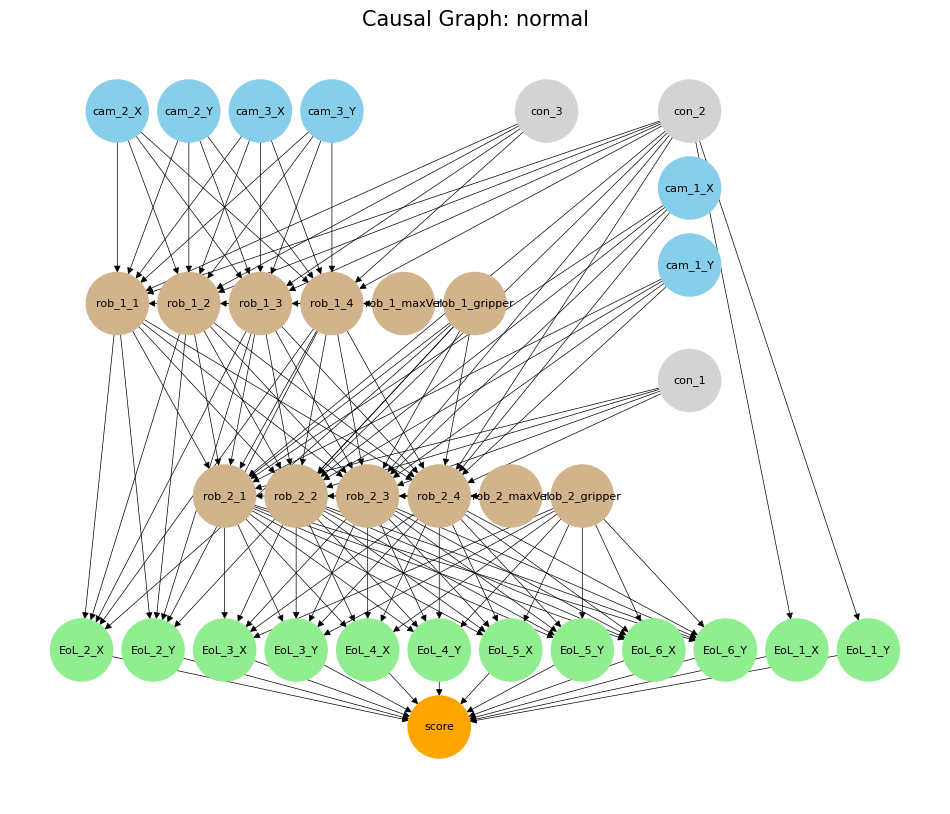

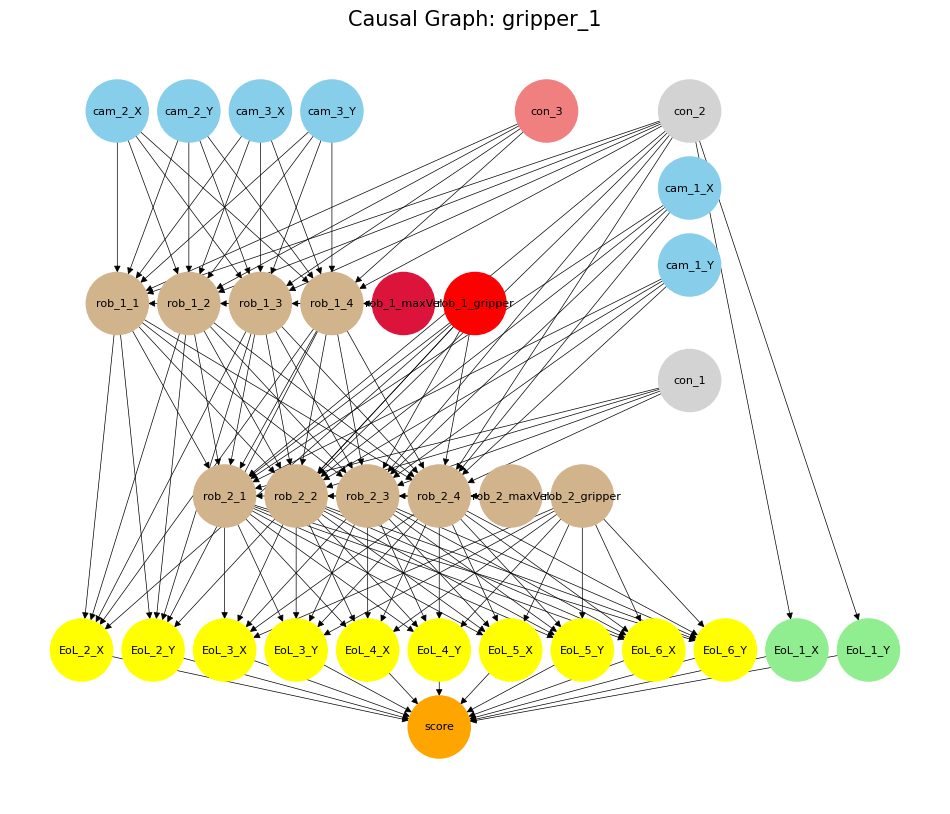

In [54]:
run_HT(folder_path,files,startrow=1000,G=G,nodes=nodes,edges=edges,key_nodes=EoL_nodes,colors=colors,pos=pos)

### Algorithm #2 - Epsilon Diagnosis

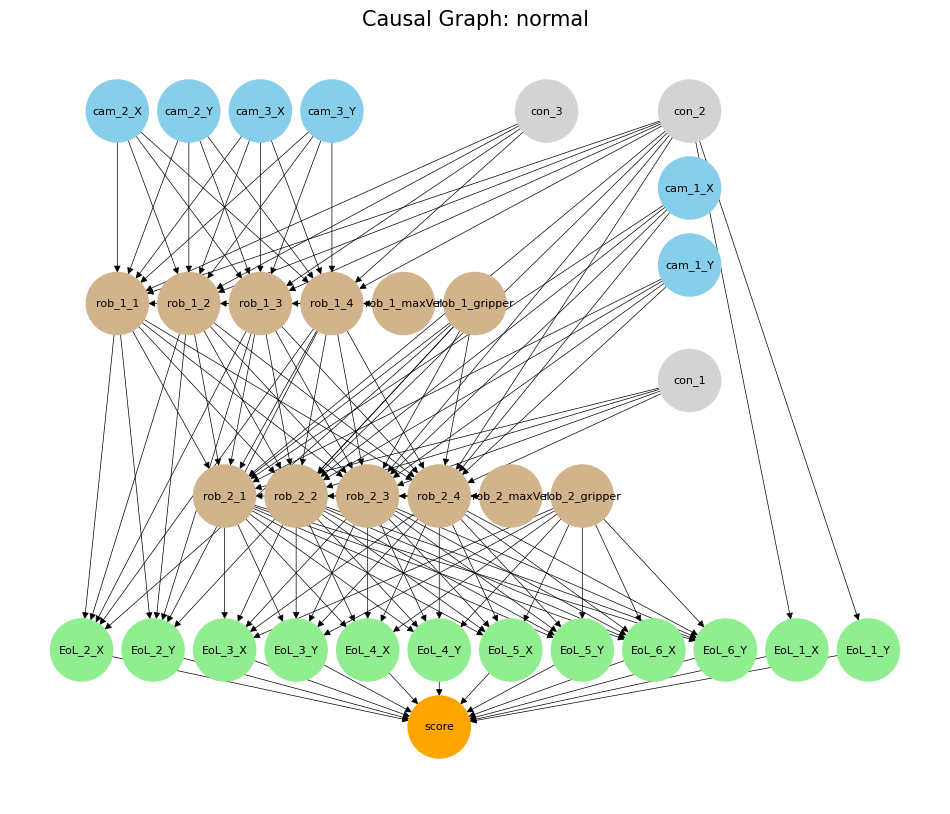

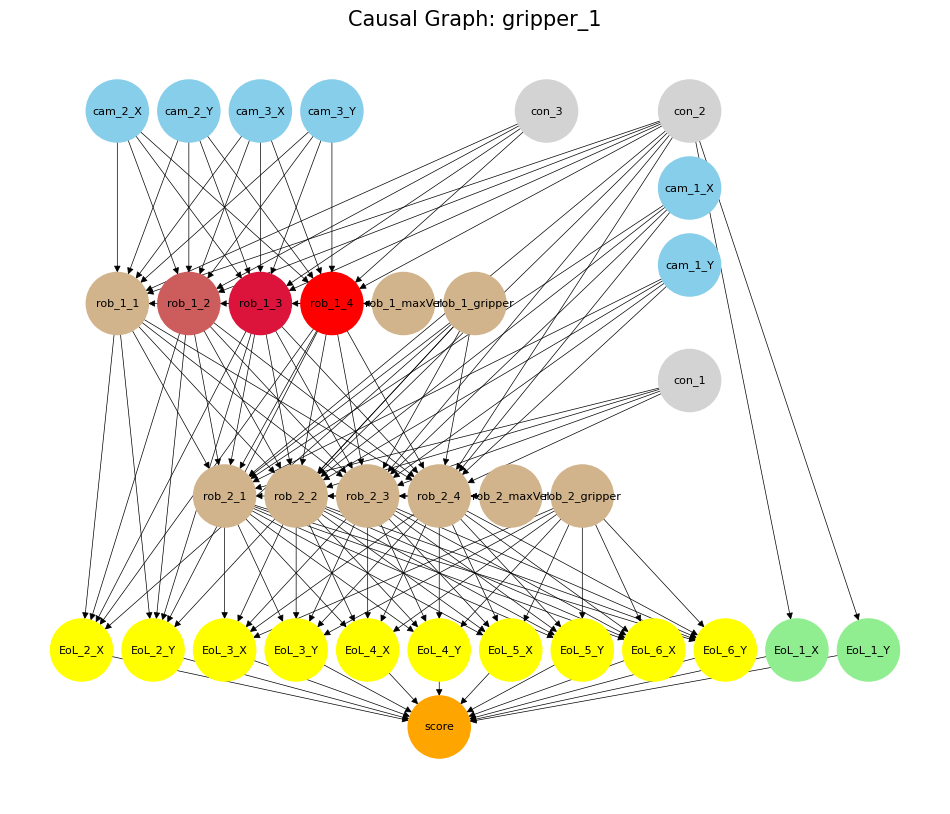

In [55]:
run_ED(folder_path,files,startrow=1000,G=G,nodes=nodes,edges=edges,key_nodes=EoL_nodes,colors=colors,pos=pos)

### Algorithm #3 - Random Walk

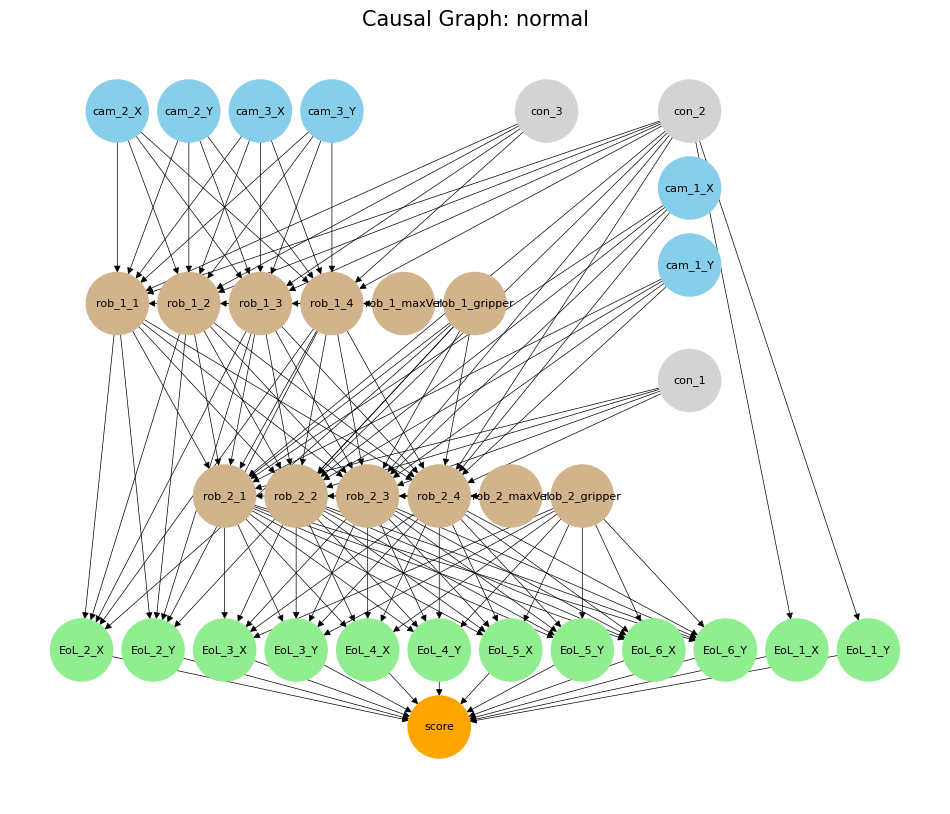

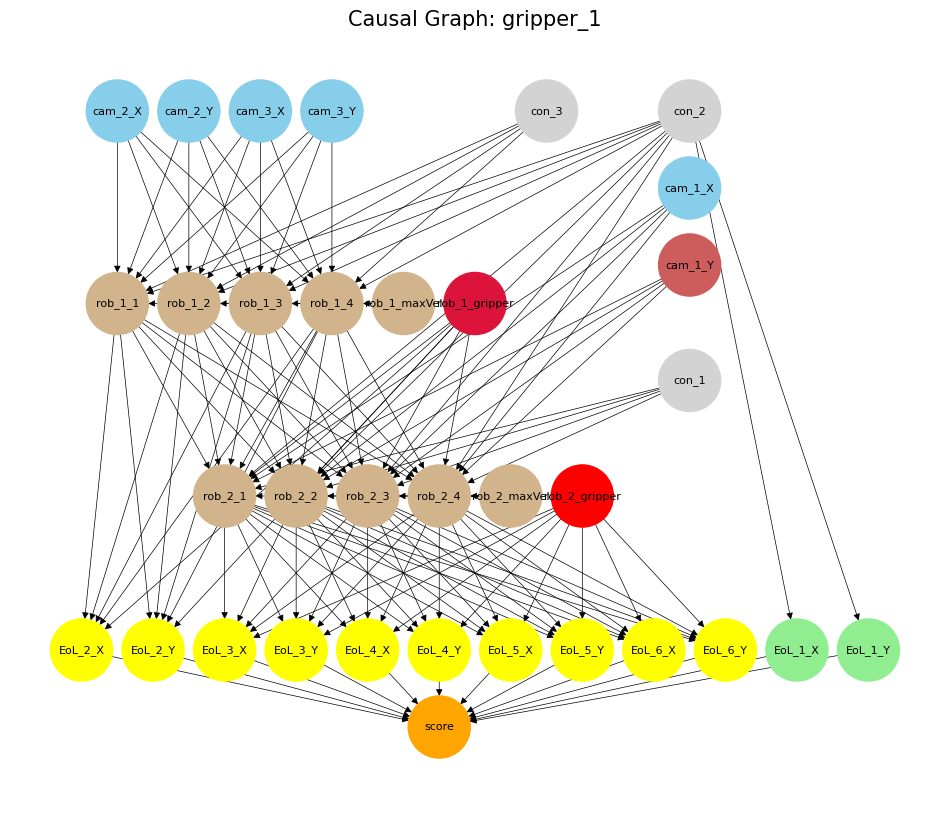

In [56]:
run_RW(folder_path,files,train_file_df,startrow=1000,G=G,nodes=nodes,edges=edges,key_nodes=EoL_nodes,colors=colors,pos=pos)

### Algorithm #4: Bayesian Network

run_BN(folder_path,files,train_file_df,startrow=1000,G=G,nodes=nodes,edges=edges,key_nodes=EoL_nodes,colors=colors,pos=pos)

#Error: The cardinality of the variable con_2 should be = 2.

### Algorithm #5: RCD

run_RCD(folder_path,files,startrow=1000,G=G,nodes=nodes,edges=edges,key_nodes=EoL_nodes,colors=colors,pos=pos)

#Error

### Algorithm #6: BARO